In [1]:
import os
os.chdir("../..")

In [2]:
%config Completer.use_jedi = False

import SimpleITK as itk
from LabelFusion.wrapper import fuse_images

import echonet
from echonet.datasets import Echo

import torch.nn.functional as F
from torchvision.models.video import r2plus1d_18
from torch.utils.data import Dataset, DataLoader, Subset
from multiprocessing import cpu_count

from src.utils.torch_utils import TransformDataset, torch_collate
# from src.utils.echo_utils import get2dPucks ### We are using a debugging version!!
from src.utils.camus_validate import cleanupSegmentation
from src.transform_utils import generate_2dmotion_field
from src.visualization_utils import categorical_dice
from src.loss_functions import huber_loss, convert_to_1hot, convert_to_1hot_tensor
from src.echonet_dataset import EDESpairs, EchoNetDynamicDataset
from src.model.R2plus1D_18_MotionNet import R2plus1D_18_MotionNet
# from src.visualization_utils import categorical_dice

import numpy as np
from scipy.signal import find_peaks
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

import random
import pickle
import time

tic, toc = (time.time, time.time)

In [3]:
%matplotlib widget
from src.strain import *

# for get2dpucks
from skimage.transform import (resize, 
                               rescale)
from skimage.segmentation import find_boundaries

In [4]:
batch_size = 4
num_workers = max(4, cpu_count()//2)


def worker_init_fn_valid(worker_id):                                                          
    np.random.seed(np.random.get_state()[1][0] + worker_id)
    

def worker_init_fn(worker_id):
    # See here: https://pytorch.org/docs/stable/notes/randomness.html#dataloader
    # and the original post of the problem: https://github.com/pytorch/pytorch/issues/5059#issuecomment-817373837
    worker_seed = torch.initial_seed() % 2 ** 32
    np.random.seed(worker_seed)
    random.seed(worker_seed)
    

def permuter(list1, list2):
    for i1 in list1:
        for i2 in list2:
            yield (i1, i2)
            

param_trainLoader = {'collate_fn': torch_collate,
                     'batch_size': batch_size,
                     'num_workers': max(4, cpu_count()//2),
                     'worker_init_fn': worker_init_fn}

param_testLoader = {'collate_fn': torch_collate,
                    'batch_size': batch_size,
                    'shuffle': False,
                    'num_workers': max(4, cpu_count()//2),
                    'worker_init_fn': worker_init_fn}

paramLoader = {'train': param_trainLoader,
               'valid': param_testLoader,
               'test':  param_testLoader}

In [5]:
with open("fold_indexes/stanford_valid_sampled_indices", "rb") as infile:
    valid_mask = pickle.load(infile)
infile.close()

test_dataset = EchoNetDynamicDataset(split='test', clip_length="full", raise_for_es_ed=False, period=1)

100%|██████████| 16/16 [00:01<00:00, 13.17it/s]


In [6]:
model_save_path = "save_models/Original_Pretrained_R2plus1DMotionSegNet.pth"

model = torch.nn.DataParallel(R2plus1D_18_MotionNet())
model.to("cuda")
torch.cuda.empty_cache()
model.load_state_dict(torch.load(model_save_path)["model"])
print(f'R2+1D MotionNet has {sum(p.numel() for p in model.parameters() if p.requires_grad)} parameters.')

model.eval();

R2+1D MotionNet has 31575731 parameters.


In [7]:
test_pat_index = 0

video, (filename, EF, es_clip_index, ed_clip_index, es_index, ed_index, es_frame, ed_frame, es_label, ed_label) = test_dataset[test_pat_index]

In [8]:
def image_to_regional_point_sets(I, N=3):
    '''
    input:
        I - image (112, 112) unique vals of (0,1)
        N - number of regions to slice
            note if this should be changed get2dPuckEndpoints npucks param needs to be divisible by N
    '''
    
    radiiEndpoints_I = get2dPuckEndpoints((I == 1).astype('int'), (1.0, 1.0), npucks=9)

    I = give_boundary_no_basal_plane(ed_label)
    
    # get the indeces of where we'll slice
    indeces_for_slice_points = []
    for i in range(len(radiiEndpoints_I)-1, 0, -N):
        indeces_for_slice_points.append(i)
    indeces_for_slice_points.sort()

    # get the actual points of where we'll slice
    slice_points = []
    for i in indeces_for_slice_points:
        slice_points.append(radiiEndpoints_I[i, 0, ...])
    slice_points = np.array(slice_points)

    # reorganize our points to be stored as (i,j)
    divide_points = [] # (i,j)
    for a in slice_points:
        divide_points.append([ [a[0][0], a[1][0]] , [a[0][1], a[1][1]] ])
        
    # convert input image into points
    I_point_set = []
    for i in range(I.shape[0]):
        for j in range(I.shape[1]):
            if I[i][j] == 1:
                I_point_set.append([i,j])

                
    # split input image point set into the regional point sets
    I_regional_point_sets = [0 for i in range(N)]
    for i in range(N):
        curr_region_point_set = []
        tmp_point_count = 0

        # first region
        if i == 0:
            p1 = ij_to_xy(divide_points[i][0])
            p2 = ij_to_xy(divide_points[i][1])

            for point in I_point_set:
                p3 = ij_to_xy(point)

                if is_point_above_below_line(p1, p2, p3) == -1:
                    curr_region_point_set.append(point)
                    tmp_point_count += 1

            print(f'points in region i={i}: {tmp_point_count}')
            print(f'{p1} {p2}')

        # 2nd and + regions
        else:
            start_p1 = ij_to_xy(divide_points[i-1][0])
            start_p2 = ij_to_xy(divide_points[i-1][1])

            end_p1 = ij_to_xy(divide_points[i][0])
            end_p2 = ij_to_xy(divide_points[i][1])

            # look at the entire point set representing the entire lv
            for point in I_point_set:
                p3 = ij_to_xy(point)

                check_1 = is_point_above_below_line(start_p1, start_p2, p3)
                check_2 = is_point_above_below_line(end_p1, end_p2, p3)

                # print(check_1, check_2)

                # above the first line and below the second line
                # save point in (i,j) format
                if check_1 == 1 and check_2 == -1:
                    curr_region_point_set.append(point)
                    tmp_point_count += 1

            print(f'points in region i={i}: {tmp_point_count}')
            print(f'{start_p1} {start_p2} | {end_p1} {end_p2}')

        # save curr region point set
        I_regional_point_sets[i] = np.array(curr_region_point_set)

    I_regional_point_sets = np.array(I_regional_point_sets)
    
    return I_regional_point_sets

In [9]:
I_regional_point_sets = image_to_regional_point_sets(ed_label)

points in region i=0: 36
[48.05716979 38.44081952] [68.001712   35.98958544]
points in region i=1: 39
[48.05716979 38.44081952] [68.001712   35.98958544] | [47.52191566 58.24401858] [73.316329   55.07382072]
points in region i=2: 34
[47.52191566 58.24401858] [73.316329   55.07382072] | [54.88647627 77.07631067] [70.73113125 75.12896298]


/opt/anaconda3/envs/dynamic37-wang/lib/python3.7/site-packages/ipykernel_launcher.py:88: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


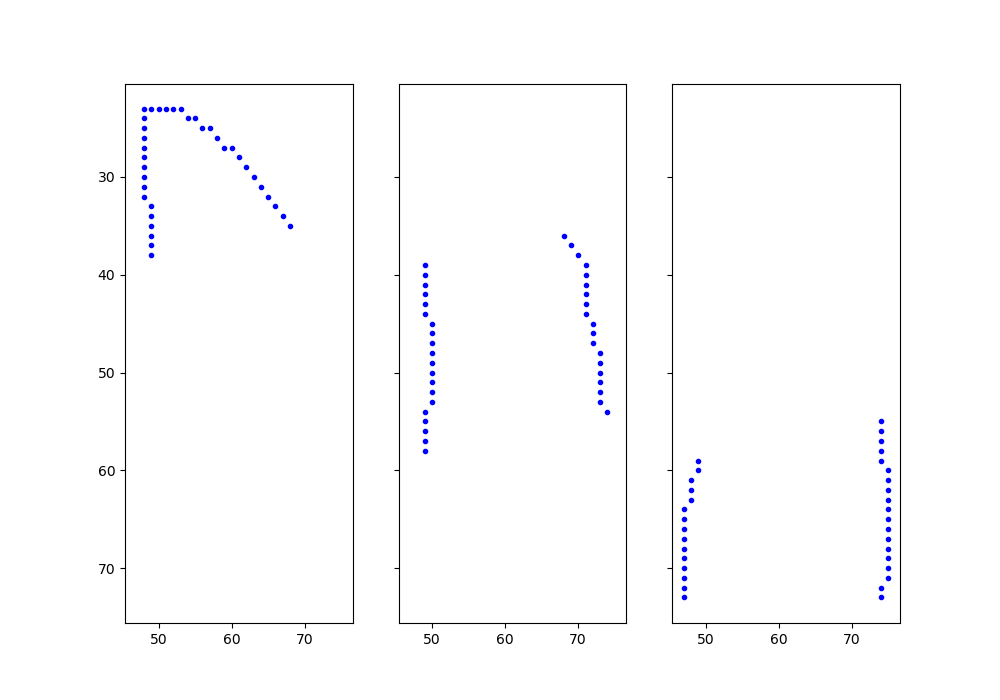

In [11]:
fig, ax = plt.subplots(1,3, figsize=(10,7), sharex = True, sharey = True)
ax[0].scatter(I_regional_point_sets[0][:, 1], I_regional_point_sets[0][:, 0], marker='.', color='b', zorder=2)
# ax[0].scatter(divide_points_j_vals, divide_points_i_vals, marker='.', color='r', zorder=3)
ax[0].invert_yaxis()

ax[1].scatter(I_regional_point_sets[1][:, 1], I_regional_point_sets[1][:, 0], marker='.', color='b', zorder=2)
# ax[1].scatter(divide_points_j_vals, divide_points_i_vals, marker='.', color='r', zorder=3)
ax[1].invert_yaxis()

ax[2].scatter(I_regional_point_sets[2][:, 1], I_regional_point_sets[2][:, 0], marker='.', color='b', zorder=2)
# ax[2].scatter(divide_points_j_vals, divide_points_i_vals, marker='.', color='r', zorder=3)
ax[2].invert_yaxis()